In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, round, sum, avg, month
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, desc, to_date
spark = SparkSession.builder.appName("RideShareAnalytics").getOrCreate()


In [0]:
drivers_df = spark.read.csv("/FileStore/tables/drivers.csv", header=True, inferSchema=True)
rides_df   = spark.read.csv("/FileStore/tables/rides.csv",   header=True, inferSchema=True)
feedback_df= spark.read.csv("/FileStore/tables/feedback.csv",header=True, inferSchema=True)

In [0]:
rides_df = rides_df.withColumn("distance_km", col("distance_km").cast("double")) \
                   .withColumn("price", col("price").cast("double")) \
                   .withColumn("ride_date", to_date(col("ride_date"), "yyyy-MM-dd"))

drivers_df = drivers_df.withColumn("experience_years", col("experience_years").cast("int")) \
                       .withColumn("rating", col("rating").cast("double"))

In [0]:
display(drivers_df)
display(rides_df)
display(feedback_df)

driver_id,driver_name,city,experience_years,rating
1,Arun Kumar,Bangalore,4,4.6
2,Pooja Rao,Chennai,2,4.3
3,Imran Sheikh,Delhi,6,4.8
4,Nisha Patel,Hyderabad,1,4.0
5,Rajesh Naik,Mumbai,8,4.9
6,Sneha Menon,Bangalore,3,4.4


ride_id,driver_id,distance_km,price,ride_date
1001,1,10.0,250.0,2024-02-01
1002,2,7.0,180.0,2024-02-03
1003,3,15.0,500.0,2024-02-05
1004,4,5.0,120.0,2024-02-08
1005,1,12.0,300.0,2024-02-10
1006,5,20.0,800.0,2024-02-15
1007,6,9.0,230.0,2024-02-20
1008,7,11.0,270.0,2024-02-22


ride_id,customer_feedback
1001,Excellent
1002,Good
1003,Excellent
1004,Average
1005,Good
1006,Excellent
1007,Average
1008,Good


In [0]:
rides_missing_driver = rides_df.join(drivers_df, "driver_id", "left_anti")
display(rides_missing_driver)

driver_id,ride_id,distance_km,price,ride_date
7,1008,11.0,270.0,2024-02-22


In [0]:
rides_with_drivers = rides_df.join(drivers_df, "driver_id", "left")
display(rides_with_drivers)

driver_id,ride_id,distance_km,price,ride_date,driver_name,city,experience_years,rating
1,1001,10.0,250.0,2024-02-01,Arun Kumar,Bangalore,4,4.6
2,1002,7.0,180.0,2024-02-03,Pooja Rao,Chennai,2,4.3
3,1003,15.0,500.0,2024-02-05,Imran Sheikh,Delhi,6,4.8
4,1004,5.0,120.0,2024-02-08,Nisha Patel,Hyderabad,1,4.0
1,1005,12.0,300.0,2024-02-10,Arun Kumar,Bangalore,4,4.6
5,1006,20.0,800.0,2024-02-15,Rajesh Naik,Mumbai,8,4.9
6,1007,9.0,230.0,2024-02-20,Sneha Menon,Bangalore,3,4.4
7,1008,11.0,270.0,2024-02-22,null,null,null,null


In [0]:
rides_with_earnings = rides_with_drivers.withColumn(
    "earnings_per_km", round(col("price") / col("distance_km"), 2)
)
display(rides_with_earnings)

driver_id,ride_id,distance_km,price,ride_date,driver_name,city,experience_years,rating,earnings_per_km
1,1001,10.0,250.0,2024-02-01,Arun Kumar,Bangalore,4,4.6,25.0
2,1002,7.0,180.0,2024-02-03,Pooja Rao,Chennai,2,4.3,25.71
3,1003,15.0,500.0,2024-02-05,Imran Sheikh,Delhi,6,4.8,33.33
4,1004,5.0,120.0,2024-02-08,Nisha Patel,Hyderabad,1,4.0,24.0
1,1005,12.0,300.0,2024-02-10,Arun Kumar,Bangalore,4,4.6,25.0
5,1006,20.0,800.0,2024-02-15,Rajesh Naik,Mumbai,8,4.9,40.0
6,1007,9.0,230.0,2024-02-20,Sneha Menon,Bangalore,3,4.4,25.56
7,1008,11.0,270.0,2024-02-22,null,null,null,null,24.55


In [0]:
revenue_per_city = rides_with_earnings.groupBy("city") \
    .agg(round(sum("price"), 2).alias("total_revenue")) \
    .orderBy(col("total_revenue").desc())
display(revenue_per_city)

city,total_revenue
Mumbai,800.0
Bangalore,780.0
Delhi,500.0
null,270.0
Chennai,180.0
Hyderabad,120.0


In [0]:
rides_with_earnings.groupBy("city").agg(avg("rating").alias("avg_rating")).orderBy(desc("avg_rating")).display()

city,avg_rating
Mumbai,4.9
Delhi,4.8
Bangalore,4.533333333333333
Chennai,4.3
Hyderabad,4.0
null,null


In [0]:
driver_earnings = rides_with_earnings.groupBy("driver_id", "driver_name", "city") \
    .agg(round(sum("price"), 2).alias("total_earnings"))

w = Window.partitionBy("city").orderBy(col("total_earnings").desc())
top_driver_per_city = driver_earnings.withColumn("rank", row_number().over(w)) \
    .filter(col("rank") == 1).drop("rank").orderBy("city")
display(top_driver_per_city)

driver_id,driver_name,city,total_earnings
7,null,null,270.0
1,Arun Kumar,Bangalore,550.0
2,Pooja Rao,Chennai,180.0
3,Imran Sheikh,Delhi,500.0
4,Nisha Patel,Hyderabad,120.0
5,Rajesh Naik,Mumbai,800.0


In [0]:
drivers_no_rides = drivers_df.join(rides_df, "driver_id", "left_anti")
display(drivers_no_rides)

driver_id,driver_name,city,experience_years,rating


In [0]:
rides_with_feedback = rides_with_earnings.join(feedback_df, on="ride_id", how="left") \
    .withColumn("performance_flag",
        when(col("customer_feedback") == "Excellent", "Top")
        .when(col("customer_feedback") == "Good", "Good")
        .when(col("customer_feedback") == "Average", "Needs Improvement")
        .otherwise("No Feedback")
    )
display(rides_with_feedback)

ride_id,driver_id,distance_km,price,ride_date,driver_name,city,experience_years,rating,earnings_per_km,customer_feedback,performance_flag
1001,1,10.0,250.0,2024-02-01,Arun Kumar,Bangalore,4,4.6,25.0,Excellent,Top
1002,2,7.0,180.0,2024-02-03,Pooja Rao,Chennai,2,4.3,25.71,Good,Good
1003,3,15.0,500.0,2024-02-05,Imran Sheikh,Delhi,6,4.8,33.33,Excellent,Top
1004,4,5.0,120.0,2024-02-08,Nisha Patel,Hyderabad,1,4.0,24.0,Average,Needs Improvement
1005,1,12.0,300.0,2024-02-10,Arun Kumar,Bangalore,4,4.6,25.0,Good,Good
1006,5,20.0,800.0,2024-02-15,Rajesh Naik,Mumbai,8,4.9,40.0,Excellent,Top
1007,6,9.0,230.0,2024-02-20,Sneha Menon,Bangalore,3,4.4,25.56,Average,Needs Improvement
1008,7,11.0,270.0,2024-02-22,null,null,null,null,24.55,Good,Good


In [0]:
feedback_counts = rides_with_feedback.groupBy("customer_feedback").count().orderBy(col("count").desc())
display(feedback_counts)

customer_feedback,count
Excellent,3
Good,3
Average,2


In [0]:
rides_with_feedback.createOrReplaceTempView("rides")
drivers_df.createOrReplaceTempView("drivers")


In [0]:
spark.sql("""
SELECT r.city,
       ROUND(AVG(r.price), 2) AS avg_price,
       COUNT(*) AS rides_count
FROM rides r
WHERE r.city IS NOT NULL
GROUP BY r.city
ORDER BY avg_price DESC
""") \
.display()

city,avg_price,rides_count
Mumbai,800.0,1
Delhi,500.0,1
Bangalore,260.0,3
Chennai,180.0,1
Hyderabad,120.0,1


In [0]:
rides_with_feedback.coalesce(1).write.mode("overwrite").option("header", "true") \
    .csv("/FileStore/tables/rides_summary")

display(dbutils.fs.ls("/FileStore/tables/rides_summary"))

path,name,size,modificationTime
dbfs:/FileStore/tables/rides_summary/_SUCCESS,_SUCCESS,0,1759838301000
dbfs:/FileStore/tables/rides_summary/_committed_8784006049558018096,_committed_8784006049558018096,112,1759838301000
dbfs:/FileStore/tables/rides_summary/_started_8784006049558018096,_started_8784006049558018096,0,1759838300000
dbfs:/FileStore/tables/rides_summary/part-00000-tid-8784006049558018096-fdb196a2-7264-4ebb-ad9f-59d55bb44c4b-71-1-c000.csv,part-00000-tid-8784006049558018096-fdb196a2-7264-4ebb-ad9f-59d55bb44c4b-71-1-c000.csv,723,1759838301000


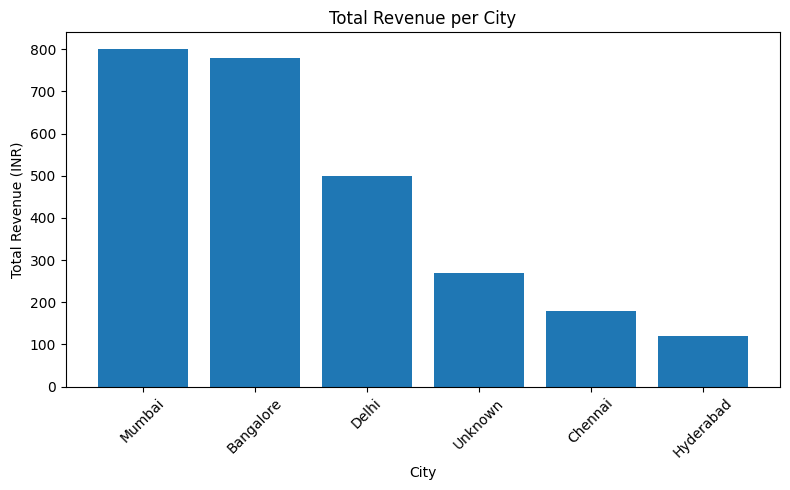

In [0]:
revenue_pd = revenue_per_city.toPandas()
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(revenue_pd['city'].fillna("Unknown"), revenue_pd['total_revenue'])
plt.title("Total Revenue per City")
plt.xlabel("City")
plt.ylabel("Total Revenue (INR)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()